In [1]:
#To do______

# response times? Can't do, would need different data
# compare best models from different counties to see which counties have better models and why
# Write a function to add 0's and averages to processedfs with missing rows
# graph more than just the test data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM



In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
#would like to add some variation for numCallTypes
def buildModel(dfScaled, numCallTypes, length, split = .9):

  reframed = series_to_supervised(dfScaled.drop(['Date','Year'], axis=1).values, length, 1)
  values = reframed.values
  split = int(split*len(values))
  train = values[:split, :]
  test = values[split:, :]

  train_X, train_y = train[:, :length*(numCallTypes+1)], train[:, -(numCallTypes + 1):]
  test_X, test_y = test[:, :length*(numCallTypes+1)], test[:, -(numCallTypes + 1):]

  train_X = train_X.reshape((train_X.shape[0], length, numCallTypes+1))
  test_X = test_X.reshape((test_X.shape[0], length, numCallTypes+1))


  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(numCallTypes + 1))
  model.compile(loss='mae', optimizer='adam')

  history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
  #models.append(model)

  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()
  return test_X, train_X, test_y, train_y, model

def buildModels(dfScaled, numCallTypes, lengths, split = .9):
  models = []
  test_Xs = []
  train_Xs = []
  test_ys = []
  train_ys = []

  for length in lengths:
    test_X, train_X, test_y, train_y, model = buildModel(dfScaled, numCallTypes, length)

    test_Xs.append(test_X)
    train_Xs.append(train_X)
    test_ys.append(test_y)
    train_ys.append(train_y)
    models.append(model)

  return test_Xs, train_Xs, test_ys, train_ys, models


In [5]:
#this function is unfortunately rather slow
#can take several minutes to run on larger counties
#needs to be edited so that it puts 0s on days where there are no calls reported

def processCounty(countydf,numCallTypes):
  allCodes = countydf['DispatchCode'].value_counts().index
  mostCommonCodes = allCodes[:numCallTypes]
  L = []
  D= {}
  for i in range(numCallTypes+2):
    L.append([])

  #change this to somehow be all dates in our date range
  dates = countydf['Date'].value_counts().sort_index().reset_index()['Date']
  counter = 0

  for date in dates:
    rows = countydf[countydf.Date == date]
    total = rows.shape[0]
    L[numCallTypes+1].append(date)
    if counter % 150 == 0:
      print(date)
    print(date) #just here to monitor progress

    #if total > 0:
    for i in range(numCallTypes):
          code = mostCommonCodes[i]
          count = rows[rows.DispatchCode == code].shape[0]
          L[i].append(count)
          total = total - count
    L[numCallTypes].append(total)
    #if total == 0:
      #append a row of 0s

  D['Date'] = L[numCallTypes+1]
  i = 0
  for code in mostCommonCodes:
    D[code] = L[i]
    i += 1
  D['everythingElse'] = L[numCallTypes]

  countydfProcessed = pd.DataFrame.from_dict(D)
  countydfProcessed['Year']=countydfProcessed.Date.apply(lambda x : x.year)
  print('_________DONE WITH THIS ONE__________________________________')
  return countydfProcessed


In [6]:
def scaleYears(df):
  D = {'Date':df['Date'], 'Year':df['Year']}
  print(len(pd.unique(df.Date)))
  L = []
  scalers = []

  for year in pd.unique(df.Year):
    scaler = MinMaxScaler()
    values = df[df.Year == year].drop(['Date','Year'], axis = 1).values
    scaler = scaler.fit(values)
    scalers.append(scaler)
    L.append(pd.DataFrame(scaler.transform(values)))

  dfScaled = pd.concat(L).reset_index(drop=True)
  dfScaled = pd.concat([pd.DataFrame.from_dict(D), dfScaled], axis=1)
  dfScaled.columns = ['Date','Year'] + list(df.columns)[1:5]
  return dfScaled, scalers

def unscaleYears(df, scalers):
  D = {'Date':df['Date'], 'Year':df['Year']}
  L = []
  for i in range(len(scalers)):
    scaler = scalers[i]
    #print(i+2018)
    values = df[df.Year == 2018+i].drop(['Date','Year'], axis = 1).values
    #print(values)
    L.append(pd.DataFrame(scaler.inverse_transform(values)))
  dfUnscaled = pd.concat(L).reset_index(drop=True)
  dfUnscaled = pd.concat([pd.DataFrame.from_dict(D), dfUnscaled], axis=1)
  dfUnscaled.columns = ['Date','Year'] + list(df.columns)[2:6]
  return dfUnscaled

In [13]:
def evaluateModels(models, test_Xs, test_ys, scalers):
  MSEs = []
  #all the test_y's are actually the same....
  #These are the targets
  #We use the last scaler, because all this test data takes place in the last year
  inv_ys = [scalers[-1].inverse_transform(test_y) for test_y in test_ys]
  inv_y = inv_ys[0]
  #inv_ys = [scalers[-1].inverse_transform(test_y) for test_y in test_ys]
  average_row = pd.DataFrame(inv_y).describe().values[1,:]

  #this represents predicting the average every single day
  average_pred = np.array([average_row for i in range(len(inv_y))])
  MSEs.append(mean_squared_error(inv_y, average_pred))

  #the naive model predicts what happened yesterday for today everytime
  naive_pred = [average_row]     #start with the average, cause we don't know what happened yesterday
  for i in range(1,len(inv_y)):
    naive_pred.append(inv_y[i-1])
  naive_pred = np.array(naive_pred)
  MSEs.append(mean_squared_error(inv_y, naive_pred))

  #these are the predictions of each model
  inv_yhats = [scalers[-1].inverse_transform(models[i].predict(test_Xs[i])) for i in range(len(models))]

  #Create the MSE for each model and add these labels for graphing
  x = ['average','naive']
  i = 0
  for inv_yhat in inv_yhats:
    inv_y = inv_ys[i]
    MSEs.append(mean_squared_error(inv_y, inv_yhat))
    x.append('model '+ str(i))
    i += 1

  #Do some plotting
  fig, ax = plt.subplots()
  ax.bar(x = x, height = MSEs)
  ax.set_title('MSE of different models')
  ax.set_ylabel('MSE')

  fig, axs = plt.subplots(numCallTypes+1,sharex=True,figsize = (15,10))

  for i in range(numCallTypes+1):
    inv_y = inv_ys[i]
    #these three lines have to be done every time because they depend on the size of inv_y which depends somehow on the model's window length
    stupid = [i for i in range(len(inv_y))]
    average_row = pd.DataFrame(inv_y).describe().values[1,:]
    average_pred = np.array([average_row for i in range(len(inv_y))])

    for j in range(-3,len(models)):
        if j == -3:
          axs[i].plot(stupid, inv_y[:,i], label='targets')
        if j == -2:
          axs[i].plot(stupid, average_pred[:,i], label='average')
        if j == -1:
          print('blah')
          #axs[i].plot(stupid, naive_pred[:,i], label='average')
        if j >= 0:
          stupid = [i for i in range(len(inv_yhats[j]))]
          axs[i].plot(stupid, inv_yhats[j][:,i], label='model '+ str(j) + ' predictions')
    axs[i].legend(fontsize = 'xx-small')

  return inv_y, inv_yhats, x, MSEs

In [8]:
#you must accept ALL permissions or you will get an error
from google.colab import drive
import os
drive.mount('/content/drive')

#you should adjust this next line to run on your own computer
files = os.listdir(os.path.join(os.getcwd(), "drive", "MyDrive",'ErdosData'))
paths = [os.path.join(os.getcwd(), "drive", "MyDrive",'ErdosData', file) for file in files]

Mounted at /content/drive


In [9]:
#Load the data from a file in my google drive
L=[pd.read_csv(path,header=None, delimiter="|") for path in paths]

Totaldf=pd.concat(L, ignore_index=True)

Totaldf=Totaldf.rename(columns={0:'PcrKey',1:'CountyCode',2:'eTimes_03', 3:'DispatchCode'})
#this dataframe is one row for each call, with all the counties together
Totaldf.head()

,PcrKey,CountyCode,eTimes_03,DispatchCode
0,10906936.0,0FJ5O,2018-01-31 10:12:00,2301061
1,11073094.0,0FJ5O,2018-02-04 06:07:00,2301013
2,11073116.0,0FJ5O,2018-02-13 12:56:00,2301071
3,11073345.0,0FJ5O,2018-02-04 14:16:00,2301061
4,11073392.0,0FJ5O,2018-02-06 14:03:00,2301021


In [10]:
#Format the time for all years except 2018, 2019
Totaldf['DateTime']=pd.to_datetime(Totaldf['eTimes_03'],format='%d%b%Y:%H:%M:%S',exact=False, errors='coerce')
#The rows of year 2018, 2109 will be broken, select those rows and use a different format for them
Totaldf.loc[Totaldf.DateTime.isna(),'DateTime']=pd.to_datetime(Totaldf.loc[Totaldf.DateTime.isna(),'eTimes_03'], format='%Y-%m-%d %H:%M:%S',exact=False, errors='coerce')

#Create date and year columns
Totaldf['Date']=Totaldf.DateTime.apply(lambda x : x.date())
Totaldf['Year']=Totaldf.DateTime.apply(lambda x : x.year)

print(pd.unique(Totaldf.Year))
Totaldf.head()
#create Date column (only date without time)
#df['Notified']=pd.to_datetime(df['eTimes_03'], format='%d%b%Y:%H:%M:%S',exact=False, errors='coerce')

[2018 2019 2020 2021 2022 2023]


,PcrKey,CountyCode,eTimes_03,DispatchCode,DateTime,Date,Year
0,10906936.0,0FJ5O,2018-01-31 10:12:00,2301061,2018-01-31 10:12:00,2018-01-31,2018
1,11073094.0,0FJ5O,2018-02-04 06:07:00,2301013,2018-02-04 06:07:00,2018-02-04,2018
2,11073116.0,0FJ5O,2018-02-13 12:56:00,2301071,2018-02-13 12:56:00,2018-02-13,2018
3,11073345.0,0FJ5O,2018-02-04 14:16:00,2301061,2018-02-04 14:16:00,2018-02-04,2018
4,11073392.0,0FJ5O,2018-02-06 14:03:00,2301021,2018-02-06 14:03:00,2018-02-06,2018


In [12]:
silly = [0,1,2,3,4,5,6,7]
silly[4:6]

[4, 5]

In [11]:
#Get a list of all the counties
allCounties = Totaldf['CountyCode'].value_counts().index
countyNames = []
countydfs = []

#Many counties are missing some number of days
#Maybe there are days where there are 0 calls, but if you go and check some of these counties just have 2-3 months here and there where no calls are recorded
#To be safe, we just toss all counties that dont have 6 years worth of days
#To let this be more forgiving, you could edit the if statement to be a \geq and alter the 'processCounty' function to add 0s where there are missing days

for county in allCounties:
  totaldays = len(pd.unique(Totaldf[Totaldf.CountyCode == county].Date))
  print(county, totaldays)
  if totaldays == (365*6 + 1):
    countydfs.append(Totaldf[Totaldf.CountyCode == county])
    countyNames.append(county)

7AA9Y 2191
HKHZQ 2191
NTVRU 2060
B2C2S 2191
UPAPQ 2191
ERY72 2191
REUPY 2136
EE9PF 2046
HYAKR 2190
7WC4T 2191
FRK94 2191
LGYAG 2191
ZFOUL 1520
PNP7M 1923
7ZDLG 2188
MXY0O 2191
S673R 2189
8MKQ8 2191
9K2F1 1466
PAHPY 2191
JG2AT 2162
CL0W8 1917
KNJYA 2158
19UZK 2087
CMPA8 1449
0FJ5O 1914


In [14]:
#print(countyNames)
print(len(countydfs))
i = 0
#this gives some idea of the size of data for different counties
for county in countydfs:
  print(countyNames[i],county.shape)
  i += 1

11
7AA9Y (4614204, 7)
HKHZQ (3132673, 7)
B2C2S (2215539, 7)
UPAPQ (1251999, 7)
ERY72 (1164057, 7)
7WC4T (468527, 7)
FRK94 (374283, 7)
LGYAG (356117, 7)
MXY0O (161601, 7)
8MKQ8 (126209, 7)
PAHPY (64741, 7)


In [15]:
#This is how many of the most common calls we separate out
#some of the functions above need minor adjustments when this number isn't 3
numCallTypes = 3

#Use this next line to pare down the number of counties, makes computation faster
countydfs = countydfs[4:6]

countydfs[0].head()

,PcrKey,CountyCode,eTimes_03,DispatchCode,DateTime,Date,Year
747441,9821860.0,ERY72,2018-02-21 00:00:00,2301071,2018-02-21 00:00:00,2018-02-21,2018
747442,12185378.0,ERY72,2018-02-01 17:14:51,2301071,2018-02-01 17:14:51,2018-02-01,2018
747443,12185477.0,ERY72,2018-02-12 19:46:40,2301071,2018-02-12 19:46:40,2018-02-12,2018
747444,12185692.0,ERY72,2018-02-24 10:28:00,2301021,2018-02-24 10:28:00,2018-02-24,2018
747445,12186974.0,ERY72,2018-04-11 09:20:24,2301071,2018-04-11 09:20:24,2018-04-11,2018


In [16]:
#this block takes >20 min to run but what are you gonna do
processedCounties = [processCounty(county, numCallTypes) for county in countydfs]

processedCounties[0].head()

Streaming output truncated to the last 5000 lines.
2023-02-27
2023-02-27
2023-02-28
2023-02-28
2023-03-01
2023-03-01
2023-03-02
2023-03-02
2023-03-03
2023-03-03
2023-03-04
2023-03-04
2023-03-05
2023-03-05
2023-03-06
2023-03-06
2023-03-07
2023-03-07
2023-03-08
2023-03-08
2023-03-09
2023-03-09
2023-03-10
2023-03-10
2023-03-11
2023-03-11
2023-03-12
2023-03-12
2023-03-13
2023-03-13
2023-03-14
2023-03-14
2023-03-15
2023-03-15
2023-03-16
2023-03-16
2023-03-17
2023-03-17
2023-03-18
2023-03-18
2023-03-19
2023-03-19
2023-03-20
2023-03-20
2023-03-21
2023-03-21
2023-03-22
2023-03-22
2023-03-23
2023-03-23
2023-03-24
2023-03-24
2023-03-25
2023-03-25
2023-03-26
2023-03-26
2023-03-27
2023-03-27
2023-03-28
2023-03-28
2023-03-29
2023-03-29
2023-03-30
2023-03-30
2023-03-31
2023-03-31
2023-04-01
2023-04-01
2023-04-02
2023-04-02
2023-04-03
2023-04-03
2023-04-04
2023-04-04
2023-04-05
2023-04-05
2023-04-06
2023-04-06
2023-04-07
2023-04-07
2023-04-08
2023-04-08
2023-04-09
2023-04-09
2023-04-10
2023-04-10
202

,Date,2301071,2301061,2301051,everythingElse,Year
0,2018-01-01,26,44,22,119,2018
1,2018-01-02,24,37,19,136,2018
2,2018-01-03,23,40,11,118,2018
3,2018-01-04,15,31,26,130,2018
4,2018-01-05,24,35,27,110,2018


In [17]:
#scale each of the counties and collect all the scalers for later unscaling
scaledCounties = []
allScalers = []
for i in range(len(processedCounties)):
  county = processedCounties[i]
  county, scalers = scaleYears(county)
  scaledCounties.append(county)
  allScalers.append(scalers)


2191
2191


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


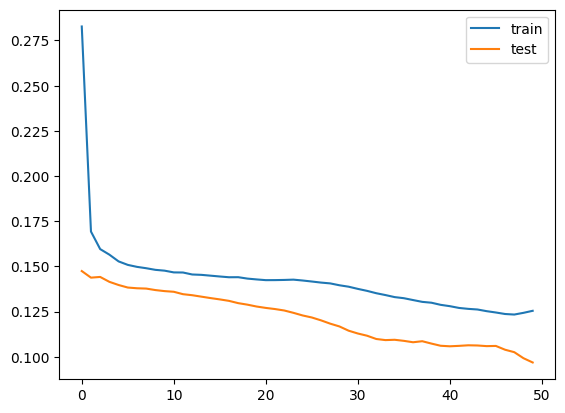

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


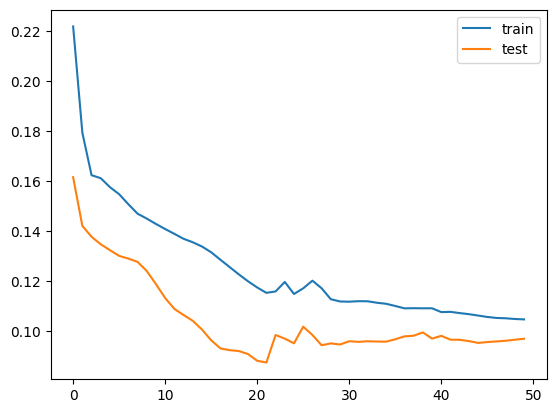

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


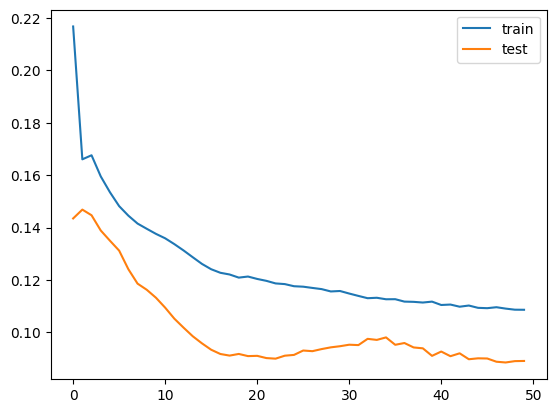

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


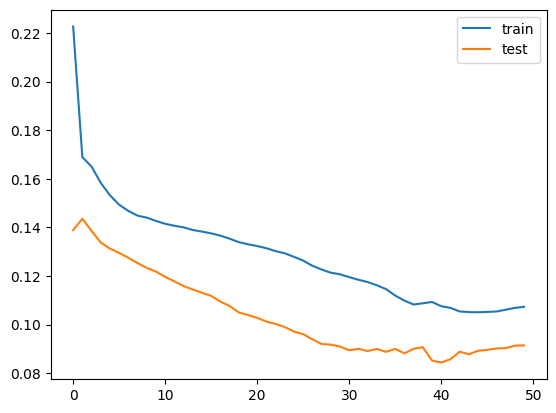

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


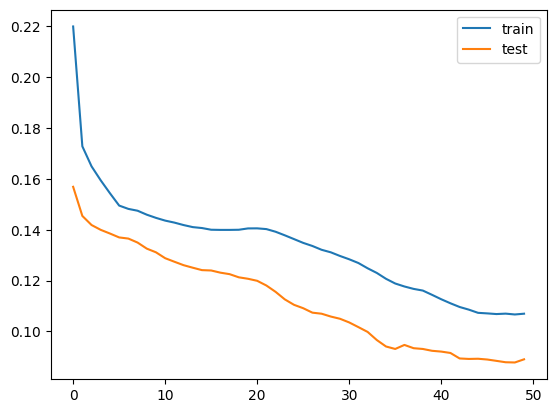

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


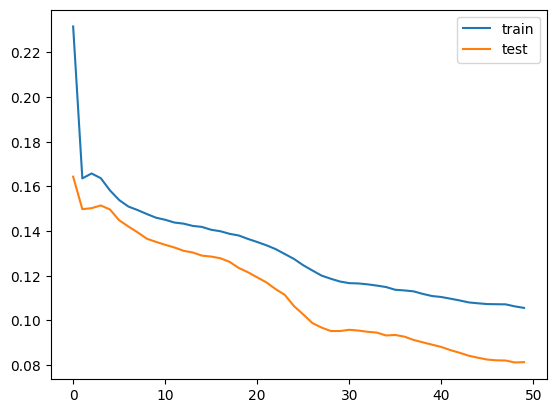

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


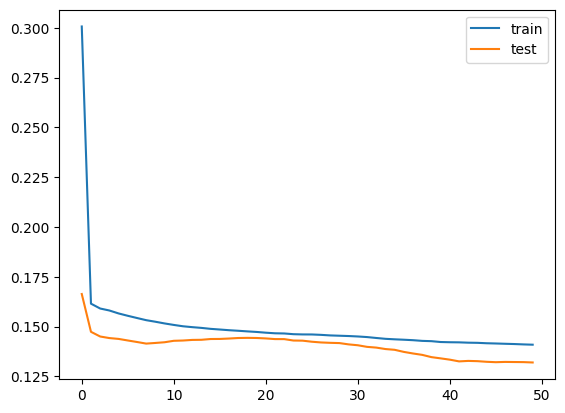

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


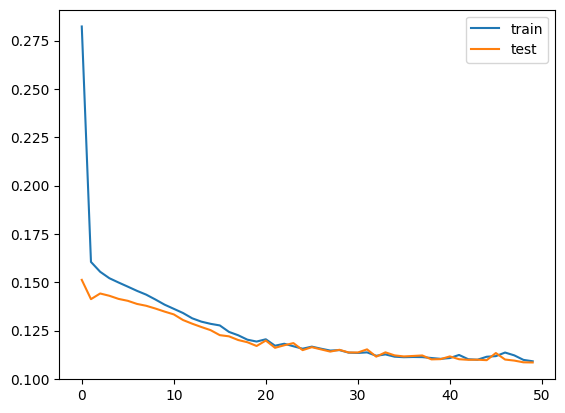

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


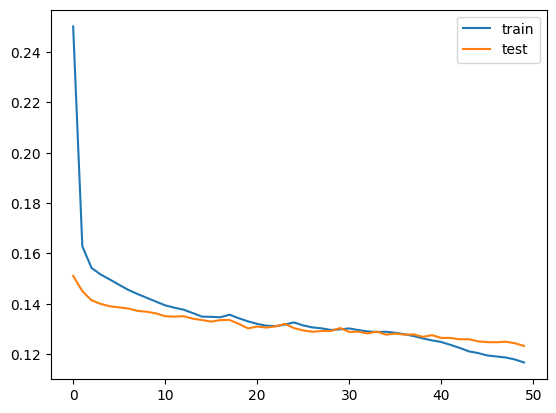

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


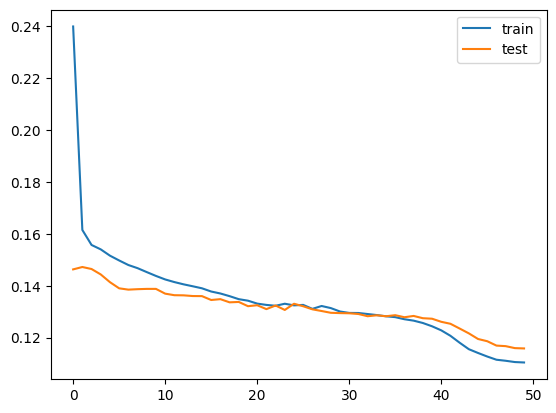

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


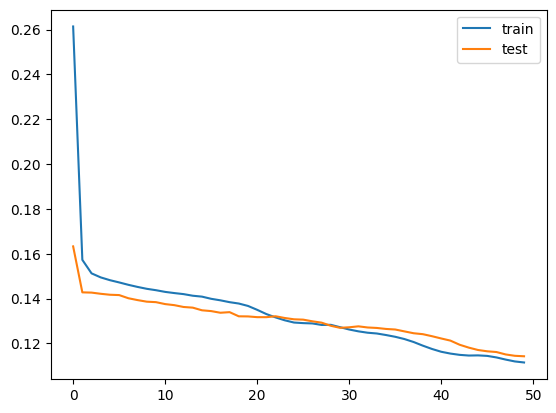

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


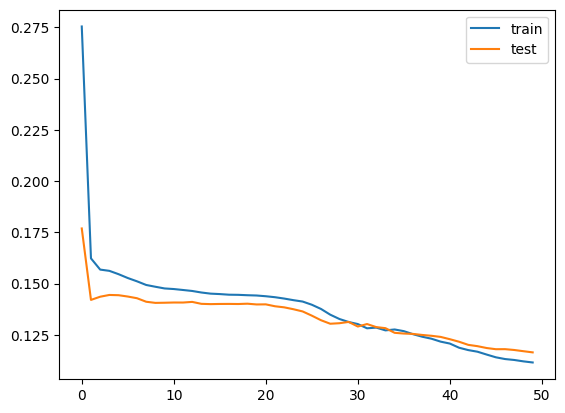

In [18]:
#After experimentation, we notice that all the best models are in this range
windowLengths = [6,7,8,9,10,11]
allModels = []
alltest_Xs = []
alltrain_Xs = []
alltest_ys = []
alltrain_ys = []

for i in range(len(scaledCounties)):
  county = scaledCounties[i]
  test_Xs, train_Xs, test_ys, train_ys, models = buildModels(county, numCallTypes, windowLengths)
  allModels.append(models)
  alltest_Xs.append(test_Xs)
  alltrain_Xs.append(train_Xs)
  alltest_ys.append(test_ys)
  alltrain_ys.append(train_ys)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
blah
blah
blah
blah
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
blah
blah
blah
blah


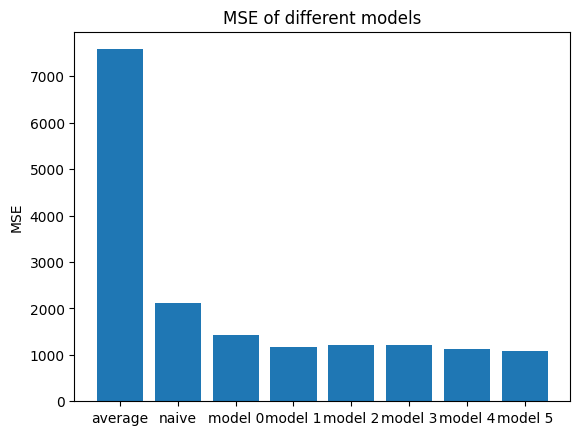

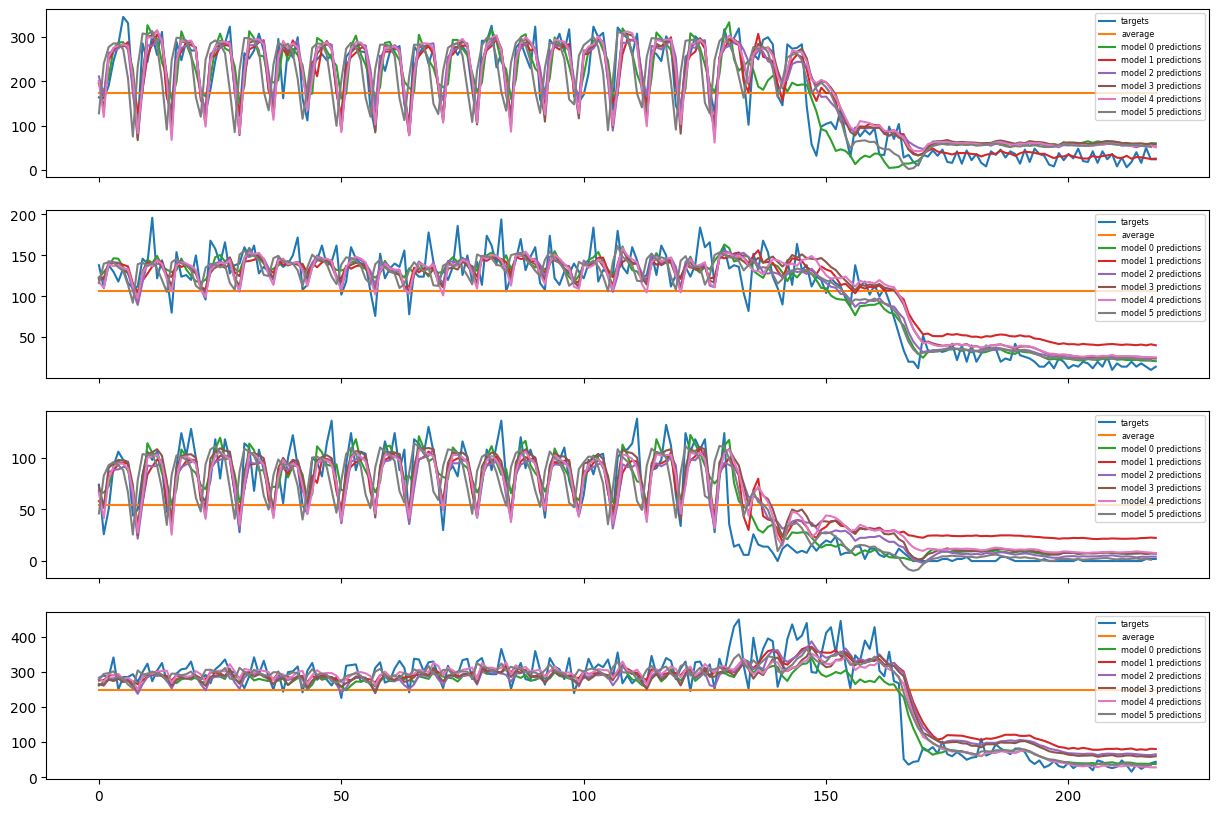

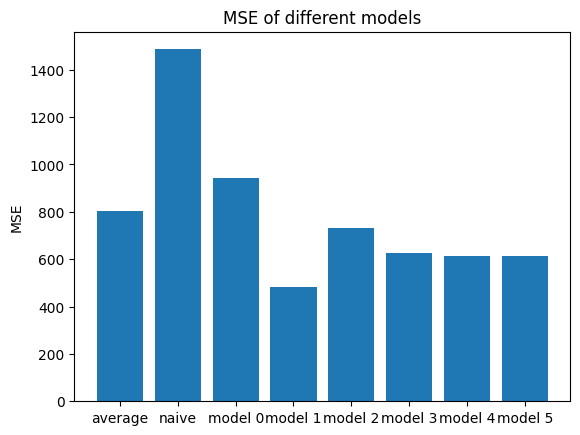

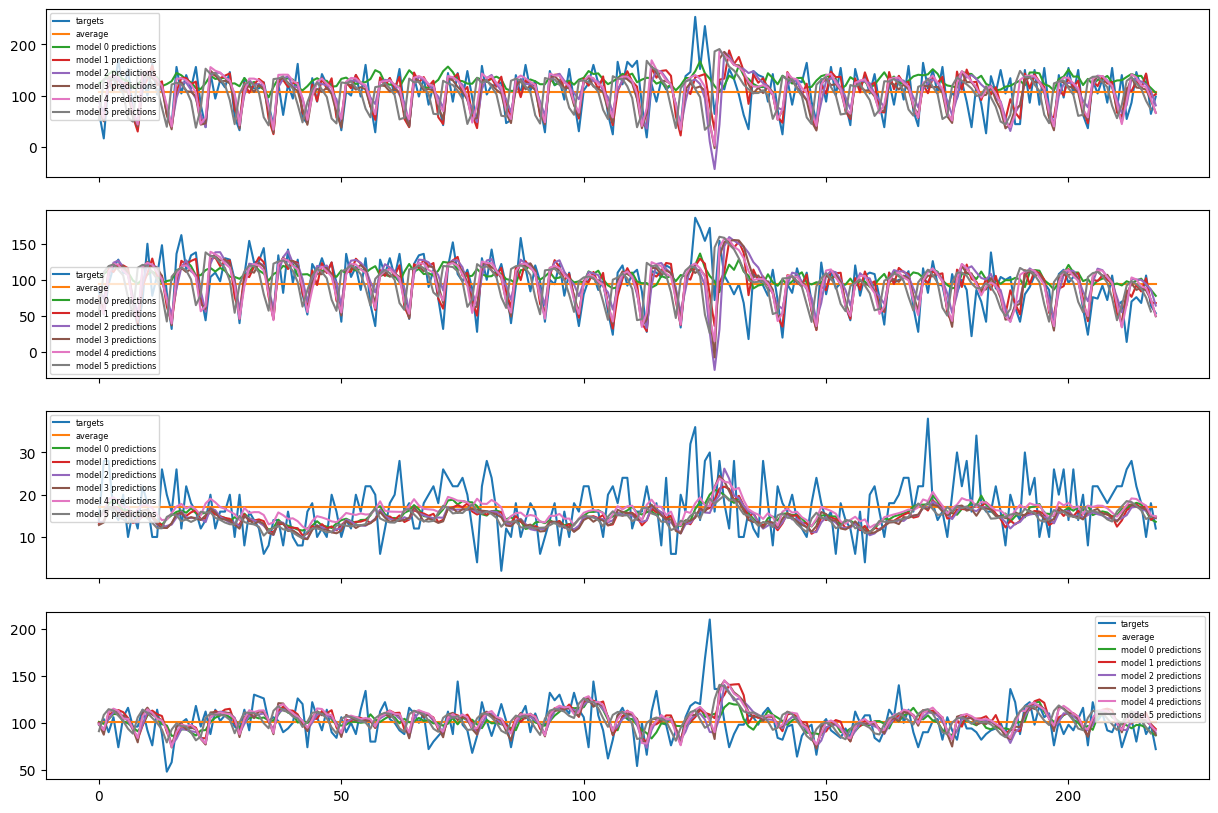

In [19]:
#Evaluate each of the models with a bar chart of the MSEs and plotting how they do on each call type and everything else
#We don't plot hte naive predictions because it only makes the chart more confusing

for i in range(0,len(allModels)):
  evaluateModels(allModels[i], alltest_Xs[i], alltest_ys[i], allScalers[i])

['ERY72', '7WC4T']

In [ ]:
#This might be something somebody wants somewhere
def evaluateModelsNoScaling(models, test_Xs, test_ys, scalers):
  MSEs = []
  #all the test_y's are actually the same....
  #These are the targets
  #We use the last scaler, because all this test data takes place in the last year
  inv_ys = test_ys
  inv_y = inv_ys[0]
  average_row = pd.DataFrame(inv_y).describe().values[1,:]

  #this represents predicting the average every single day
  average_pred = np.array([average_row for i in range(len(inv_y))])
  MSEs.append(mean_squared_error(inv_y, average_pred))

  #these are the predictions of each model
  inv_yhats = [models[i].predict(test_Xs[i]) for i in range(len(models))]

  #Create the MSE for each model
  x = ['average']
  i = 0
  for inv_yhat in inv_yhats:
    inv_y = inv_ys[i]
    MSEs.append(mean_squared_error(inv_y, inv_yhat))
    x.append('model '+ str(i))
    i += 1

  #Do some plotting
  fig, ax = plt.subplots()
  ax.bar(x = x, height = MSEs)
  ax.set_title('MSE of different models')
  ax.set_ylabel('MSE')

  fig, axs = plt.subplots(numCallTypes+1,sharex=True,figsize = (15,10))

  for i in range(numCallTypes+1):
    inv_y = inv_ys[i]
    #these three lines have to be done every time because they depend on the size of inv_y which depends somehow on the model's window length
    stupid = [i for i in range(len(inv_y))]
    average_row = pd.DataFrame(inv_y).describe().values[1,:]
    average_pred = np.array([average_row for i in range(len(inv_y))])

    for j in range(-2,len(models)):
        if j == -2:
          axs[i].plot(stupid, inv_y[:,i], label='targets')
        if j == -1:
          axs[i].plot(stupid, average_pred[:,i], label='average')
        if j >= 0:
          stupid = [i for i in range(len(inv_yhats[j]))]
          axs[i].plot(stupid, inv_yhats[j][:,i], label='model '+ str(j) + ' predictions')
    axs[i].legend(fontsize = 'xx-small')

  return inv_y, inv_yhats, x, MSEs

In [ ]:
#I started writing code that would add 0s to counties missing days

import datetime
#this is where we test the processCounty which adds in 0s
countydf = countydfs[0]
print(len(pd.unique(countydf.Date))) # - 2046 < 365 * 6

dates = countydf['Date'].value_counts().sort_index().reset_index()['Date'].values

first_day = datetime.date(2018,1,1)
iterator = pd.Timedelta(days=1)

true_dates = []
for i in range(6*365+1):
  true_dates.append(first_day)
  first_day = first_day + iterator

total = 0
for date in true_dates:
  if date not in dates:
    print(date)
    total += 1
print(6*365 - total)

2046
2018-06-16
2018-06-19
2018-06-22
2018-06-23
2018-06-24
2018-06-25
2018-06-26
2018-06-29
2018-06-30
2018-08-19
2018-08-20
2018-08-21
2018-08-22
2018-08-23
2018-08-24
2018-08-25
2018-08-26
2018-08-27
2018-08-28
2018-08-29
2018-08-30
2018-08-31
2018-09-01
2018-09-02
2018-09-03
2018-09-04
2018-09-05
2018-09-07
2018-09-08
2018-09-09
2018-09-10
2018-09-11
2018-09-12
2018-09-13
2018-09-14
2018-09-15
2018-09-16
2018-09-17
2018-09-18
2018-09-19
2018-09-20
2018-09-21
2018-09-22
2018-09-23
2018-09-24
2018-09-25
2018-09-26
2018-09-27
2018-09-28
2018-09-29
2018-09-30
2018-11-17
2018-11-18
2018-11-19
2018-11-20
2018-11-21
2018-11-22
2018-11-23
2018-11-24
2018-11-25
2018-11-27
2018-11-28
2018-11-29
2018-11-30
2018-12-01
2018-12-02
2018-12-03
2018-12-04
2018-12-05
2018-12-06
2018-12-07
2018-12-08
2018-12-10
2018-12-11
2018-12-12
2018-12-13
2018-12-14
2018-12-15
2018-12-16
2018-12-17
2018-12-18
2018-12-19
2018-12-20
2018-12-21
2018-12-22
2018-12-23
2018-12-24
2018-12-25
2018-12-26
2018-12-27
2018-

(300, 1, 4) (300, 4) (64, 1, 4) (64, 4)
